<a href="https://colab.research.google.com/github/hanifiqbl/UAS-BIG-DATA-LANJUT-22.11.5051/blob/main/UAS_BID_DATA_LANJUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tipe Data:
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)


Nilai Kosong Sebelum Imputasi:
+-------+-----------+--------+-----------------+-----------------+----------------+-------------+------------------+--------------------+--------+------------------+-----------+
|sum(ID)|sum(Gender)|sum(Age)|sum(Hypertension)|sum(HeartDisease)|sum(EverMarried)|sum(WorkType)|sum(ResidenceType)|sum(AvgGlucoseLevel)|sum(BMI)|sum(SmokingStatus)|sum(Stroke)|
+-------+-----------+--------+-----------------+-----------------+----------------+-------------

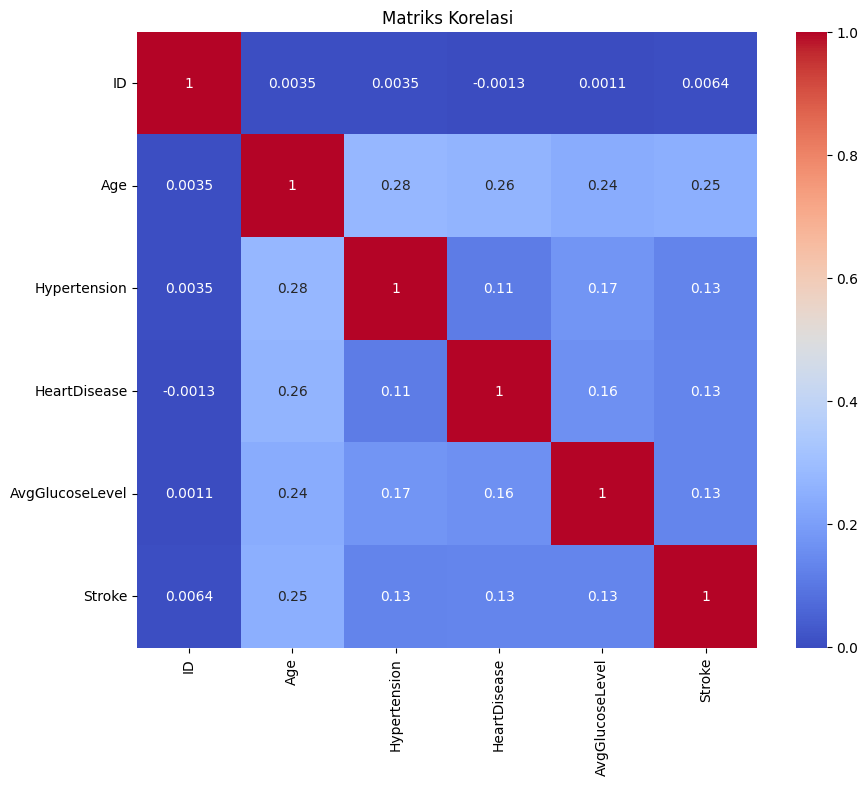

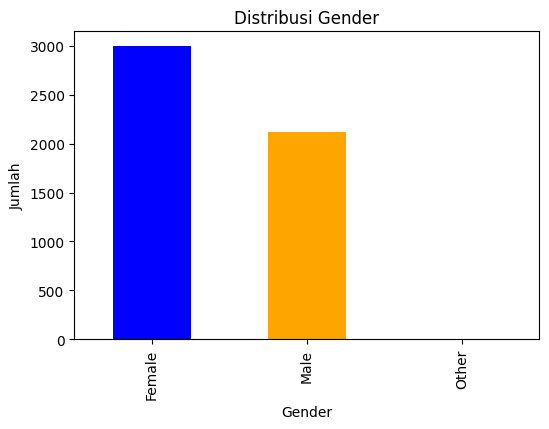

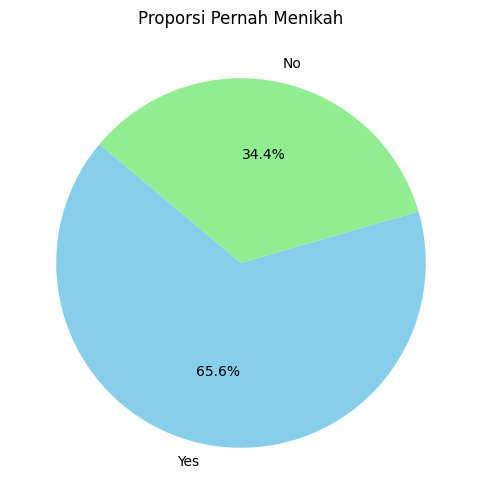

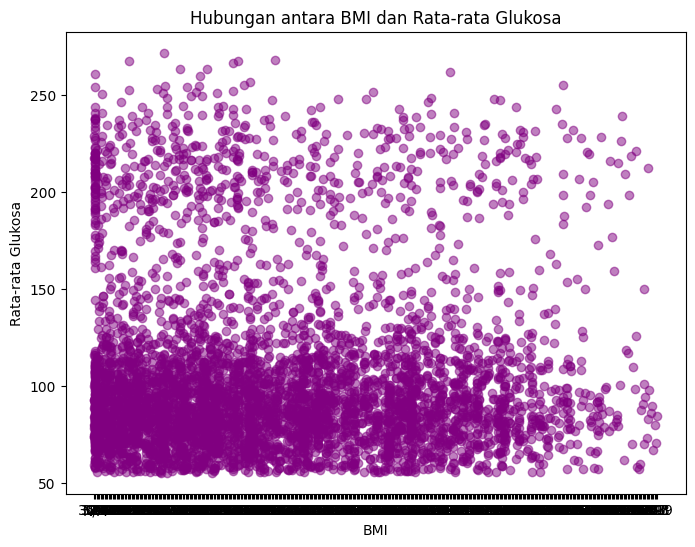

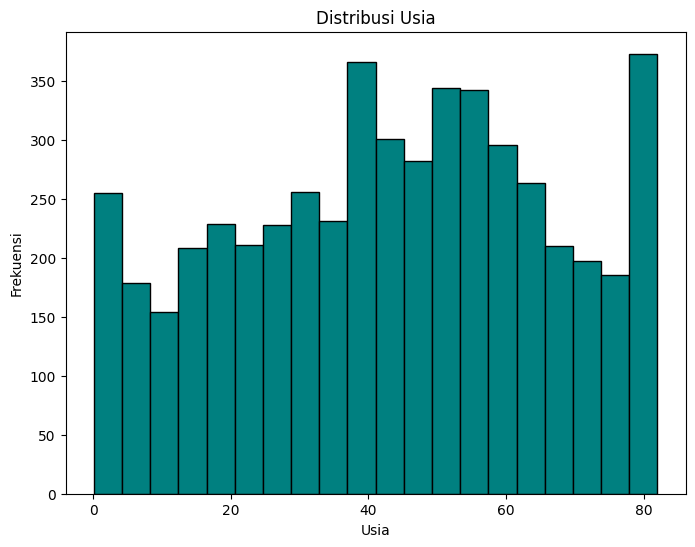

In [ ]:
# Poin (c): Preprocessing Data dengan PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, avg

# Membuat SparkSession
spark = SparkSession.builder.appName("StrokePrediction").getOrCreate()

# Load dataset
data_path = '/healthcare-dataset-stroke-data.csv'
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Pemeriksaan tipe data
print("Tipe Data:")
data.printSchema()

# Mengganti nama kolom agar lebih mudah dipahami
columns_rename = {
    'id': 'ID',
    'gender': 'Gender',
    'age': 'Age',
    'hypertension': 'Hypertension',
    'heart_disease': 'HeartDisease',
    'ever_married': 'EverMarried',
    'work_type': 'WorkType',
    'Residence_type': 'ResidenceType',
    'avg_glucose_level': 'AvgGlucoseLevel',
    'bmi': 'BMI',
    'smoking_status': 'SmokingStatus',
    'stroke': 'Stroke'
}
for old_name, new_name in columns_rename.items():
    data = data.withColumnRenamed(old_name, new_name)

#  Menangani nilai kosong (null)
print("\nNilai Kosong Sebelum Imputasi:")
null_counts = data.select([(col(c).isNull().cast("int").alias(c)) for c in data.columns]).groupBy().sum()
null_counts.show()

# Mengisi nilai kosong pada BMI dengan median
bmi_median = data.selectExpr("percentile_approx(BMI, 0.5)").collect()[0][0]
data = data.fillna({"BMI": bmi_median})

#  Mengubah tipe data jika diperlukan (contoh: Gender menjadi kategori)
data = data.withColumn("Gender", col("Gender").cast("string"))
data = data.withColumn("EverMarried", col("EverMarried").cast("string"))
data = data.withColumn("WorkType", col("WorkType").cast("string"))
data = data.withColumn("ResidenceType", col("ResidenceType").cast("string"))
data = data.withColumn("SmokingStatus", col("SmokingStatus").cast("string"))

#  Menampilkan ringkasan data
print("\nRingkasan Data:")
data.describe().show()

#  Menampilkan matriks korelasi
numeric_columns = [
    field.name for field in data.schema.fields if field.dataType.simpleString() in ["double", "int"]
]
corr_data = data.select(numeric_columns).toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi')
plt.show()

# Poin (d): Exploratory Data Analysis (EDA)
import pandas as pd

# Mengonversi data PySpark menjadi Pandas untuk visualisasi
pandas_data = data.toPandas()

#  Bar Chart: Distribusi Gender
plt.figure(figsize=(6, 4))
pandas_data['Gender'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribusi Gender')
plt.xlabel('Gender')
plt.ylabel('Jumlah')
plt.show()

#  Pie Chart: Proporsi Individu yang Pernah Menikah
plt.figure(figsize=(6, 6))
pandas_data['EverMarried'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.title('Proporsi Pernah Menikah')
plt.ylabel('')
plt.show()

#  Scatter Plot: Hubungan antara BMI dan Rata-rata Glukosa
plt.figure(figsize=(8, 6))
plt.scatter(pandas_data['BMI'], pandas_data['AvgGlucoseLevel'], alpha=0.5, color='purple')
plt.title('Hubungan antara BMI dan Rata-rata Glukosa')
plt.xlabel('BMI')
plt.ylabel('Rata-rata Glukosa')
plt.show()

#  Histogram: Distribusi Usia
plt.figure(figsize=(8, 6))
pandas_data['Age'].plot(kind='hist', bins=20, color='teal', edgecolor='black')
plt.title('Distribusi Usia')
plt.xlabel('Usia')
plt.ylabel('Frekuensi')
plt.show()


In [ ]:
# Import library
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#  Inisialisasi Spark Session
spark = SparkSession.builder.appName("ML_Classification").getOrCreate()

#  Muat dataset
data = spark.read.csv("/healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)

#  Eksplorasi Data
print("Schema dataset:")
data.printSchema()
print("\n5 data teratas:")
data.show(5)

#  Pra-pemrosesan
# Tangani missing values
data = data.dropna()

# Identifikasi kolom kategorikal
categorical_cols = [col_name for col_name, dtype in data.dtypes if dtype == 'string']

# Konversi kolom kategorikal menjadi numerik menggunakan StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in categorical_cols]
for indexer in indexers:
    data = indexer.fit(data).transform(data)

# Update daftar feature_cols
feature_cols = [col for col in data.columns if col not in ['id', 'stroke'] + categorical_cols]

# Gunakan VectorAssembler untuk menggabungkan fitur
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
data = assembler.transform(data)

# Pastikan semua fitur berskala positif untuk Naive Bayes
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
data = scaler.fit(data).transform(data)

# Ubah kolom label menjadi numerik
label_indexer = StringIndexer(inputCol="stroke", outputCol="label")
data = label_indexer.fit(data).transform(data)

# Split data menjadi training dan testing
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

#  Model
models = {
    "RandomForest": RandomForestClassifier(labelCol="label", featuresCol="features"),
    "GBT": GBTClassifier(labelCol="label", featuresCol="features"),
    "DecisionTree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    "NaiveBayes": NaiveBayes(labelCol="label", featuresCol="features")
}

evaluations = {}
for name, model in models.items():
    try:
        # Latih model
        trained_model = model.fit(train_data)

        # Prediksi
        predictions = trained_model.transform(test_data)

        # Evaluasi
        evaluator_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
        evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
        evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
        evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
        evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

        # Simpan metrik evaluasi
        evaluations[name] = {
            "AUC": evaluator_auc.evaluate(predictions),
            "Accuracy": evaluator_accuracy.evaluate(predictions),
            "F1 Score": evaluator_f1.evaluate(predictions),
            "Precision": evaluator_precision.evaluate(predictions),
            "Recall": evaluator_recall.evaluate(predictions)
        }
    except Exception as e:
        print(f"Model {name} gagal dilatih. Error: {e}")

# Cetak hasil evaluasi
print("\nEvaluasi Model:")
for model_name, metrics in evaluations.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

#  Hyperparameter Tuning
# Pilih dua model terbaik berdasarkan AUC
sorted_models = sorted(evaluations.items(), key=lambda x: x[1]['AUC'], reverse=True)
best_models = sorted_models[:2]

# Tuning Random Forest (contoh dengan model terbaik pertama)
best_model_name = best_models[0][0]
print(f"Melakukan tuning pada model terbaik: {best_model_name}")

if best_model_name == "RandomForest":
    model_to_tune = RandomForestClassifier(labelCol="label", featuresCol="features")
    paramGrid = (ParamGridBuilder()
                 .addGrid(model_to_tune.numTrees, [10, 20, 50])
                 .addGrid(model_to_tune.maxDepth, [5, 10, 20])
                 .build())
elif best_model_name == "GBT":
    model_to_tune = GBTClassifier(labelCol="label", featuresCol="features")
    paramGrid = (ParamGridBuilder()
                 .addGrid(model_to_tune.maxDepth, [5, 10, 20])
                 .addGrid(model_to_tune.maxIter, [10, 20, 50])
                 .build())

crossval = CrossValidator(estimator=model_to_tune,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label"),
                          numFolds=3)

cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel

print("Model terbaik setelah tuning:")
print(best_model.extractParamMap())


Schema dataset:
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)


5 data teratas:
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Ye